In [29]:
# Imports 
import pdb
import os
os.environ['pyna_language'] = 'python'
import pandas as pd
import dymos as dm
import numpy as np
from labellines import labelLines

import datetime as dt
from typing import Union
import openmdao.api as om
from pyNA.src.trajectory_src.atmosphere import Atmosphere

from scipy.interpolate import RegularGridInterpolator
from pyNA.src.trajectory_src.mux import Mux
from pyNA.pyna import pyna
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [38]:
# Compute minimum thrust requirement
def compute_minimum_TS(ac_name, settings, ac, engine, z_lst=[2000*0.3048, 2000*0.3048], v_lst=[250, 250], gamma_lst=[0.0, np.arctan(0.04)*180/np.pi]):
    
    # Initialize limiting cases
    case_lst = ['OEI', '4%CG']
    nr_engine_lst = np.array([ac.n_eng - 1, ac.n_eng])

    # Create engine deck interpolant
    F_n_interp = RegularGridInterpolator((engine.deck['z'], engine.deck['M_0'], engine.deck['TS']), engine.deck['F_n'])
    
    sol = dict()
    sol['alpha'] = np.zeros(2)
    sol['c_l'] = np.zeros(2)
    sol['c_d'] = np.zeros(2) 
    sol['F_avail'] = np.zeros(2)
    sol['F_req'] = np.zeros(2)
    sol['TS'] = np.zeros(2)
    
    for i, case in enumerate(case_lst):
        # Compute atmospheric properties at ac.z_max
        prob_atm = om.Problem()
        prob_atm.model.add_subsystem("atm", Atmosphere(num_nodes=1, sealevel_atmosphere = py.sealevel_atmosphere, atmosphere_dT=10.0169))
        prob_atm.setup(force_alloc_complex=True)
        prob_atm.set_val('atm.z', z_lst[i])
        prob_atm.run_model()
        rho_0 = prob_atm.get_val('atm.rho_0')
        c_0 = prob_atm.get_val('atm.c_0')
        
        # Lift requirement for steady flight
        L = 9.80665 * ac.mtow * np.cos(gamma_lst[i] * np.pi / 180.)
        sol['c_l'][i] = L / (0.5* rho_0 * v_lst[i] ** 2 * ac.af_S_w)
        
        theta_flaps = 10.
        if ac_name == 'stca':
            theta_slats = -6.
        elif ac_name == 'a10':
            theta_slats = 0.
        
        c_l_interp = RegularGridInterpolator((ac.aero['alpha'], ac.aero['theta_flaps'], ac.aero['theta_slats']), ac.aero['c_l'])        
        c_l_data = c_l_interp((ac.aero['alpha'], theta_flaps, theta_slats))

        c_d_interp = RegularGridInterpolator((ac.aero['alpha'], ac.aero['theta_flaps'], ac.aero['theta_slats']), ac.aero['c_d'])
        c_d_data = c_d_interp((ac.aero['alpha'], theta_flaps, theta_slats))

        # Before stall
        if sol['c_l'][i] <= np.max(c_l_data):         
            # Compute required angle of attack to meet lift coefficient
            sol['alpha'][i] = np.interp(sol['c_l'][i], c_l_data, ac.aero['alpha'])

            # Compute corresponding drag coefficient
            sol['c_d'][i] = np.interp(sol['alpha'][i], ac.aero['alpha'], c_d_data)

        else:
            sol['alpha'][i] = 100.
            sol['c_d'][i] = 100.
            
        # Compute aircraft total thrust requirement
        T = (sol['c_d'][i] * 0.5 * rho_0 * v_lst[i] ** 2 * ac.af_S_w) + ac.mtow * 9.80065 * np.sin(gamma_lst[i] * np.pi / 180.)

        # Compute thrust requirement per engine
        sol['F_req'][i] = T / nr_engine_lst[i]
        
        # Compute thrust available
        sol['F_avail'][i] = F_n_interp((z_lst[i], v_lst[i] / c_0, 1.))[0]

        # Compute minimum thrust setting
        sol['TS'][i] = sol['F_req'][i] / sol['F_avail'][i]
                            
    return sol

In [39]:
TS_cutback = dict()
alpha_cutback = dict()
cl_cutback = dict()
cd_cutback = dict()
v_stall = dict()
F_req = dict()
F_avail = dict()

z = 750 #2460.*0.3048
v_lst = np.linspace(100, 300, 301)*0.514444
rho_0 = 1.1392

### NASA STCA

In [43]:
# NASA STCA 
py = pyna()
py.ac_name = 'stca'
py.case_name = 'stca'
py.engine_deck_name = "engine_deck_stca.csv"

py.initialize()
py.airframe.get_aerodynamics_deck()
py.engine.get_performance_deck_variables(fan_inlet_source=False, fan_discharge_source=False, core_source=False, jet_mixing_source=False, jet_shock_source=False)
py.engine.get_performance_deck(atmosphere_type='stratified', thrust_lapse=True)

# Compute thrust cut-back level
TS_cutback[ac_name] = np.zeros((v_lst.size, 2))
alpha_cutback[ac_name] = np.zeros((v_lst.size, 2))
cl_cutback[ac_name] = np.zeros((v_lst.size, 2))
cd_cutback[ac_name] = np.zeros((v_lst.size, 2))
F_req[ac_name] = np.zeros((v_lst.size, 2))
F_avail[ac_name] = np.zeros((v_lst.size, 2))

for j, v in enumerate(v_lst):    
    sol = compute_minimum_TS(ac_name, py.settings, py.airframe, py.engine, z_lst=[z, z], v_lst=[v, v], gamma_lst=[0.0, np.arctan(0.04)*180/np.pi])

    TS_cutback[ac_name][j,:] = np.minimum(sol['TS'], 1)
    
# Compute stall speed
v_stall[ac_name] = np.sqrt(2*py.airframe.mtow*9.80665/rho_0/py.airframe.af_S_w/1.2)

# Print cases
sol = compute_minimum_TS(ac_name, py.settings, py.airframe, py.engine, z_lst=[z, z], v_lst=[197*0.514444, 197*0.514444], gamma_lst=[0.0, np.arctan(0.04)*180/np.pi]); print('V2+20: ', np.max(sol['TS']))
sol = compute_minimum_TS(ac_name, py.settings, py.airframe, py.engine, z_lst=[z, z], v_lst=[250*0.514444, 250*0.514444], gamma_lst=[0.0, np.arctan(0.04)*180/np.pi]); print('Vmax: ', np.max(sol['TS']))

sol = compute_minimum_TS(ac_name, py.settings, py.airframe, py.engine, z_lst=[z, z], v_lst=[1.4*v_stall['stca'], 1.4*v_stall['stca']], gamma_lst=[0.0, np.arctan(0.04)*180/np.pi]); print('1.4*V_stall: ', sol['TS'][0])



V2+20:  0.73007304245675
Vmax:  0.4007708741651456
1.4*V_stall:  0.7288657197843702


### GT Medium SST

In [47]:
# GT Medium SST 
ac_name = 'a10' 
py = pyna()
py.case_name = 'a10'
py.ac_name = 'a10'
py.engine_deck_name = "engine_deck_a10.csv"

py.initialize()
py.airframe.get_aerodynamics_deck()
py.engine.get_performance_deck_variables(fan_inlet_source=False, fan_discharge_source=False, core_source=False, jet_mixing_source=False, jet_shock_source=False)
py.engine.get_performance_deck(atmosphere_type='stratified', thrust_lapse=True)

# Compute thrust cut-back level
TS_cutback[ac_name] = np.zeros((v_lst.size, 2))
alpha_cutback[ac_name] = np.zeros((v_lst.size, 2))
cl_cutback[ac_name] = np.zeros((v_lst.size, 2))
cd_cutback[ac_name] = np.zeros((v_lst.size, 2))

for j, v in enumerate(v_lst):
    sol = compute_minimum_TS(ac_name, py.settings, py.airframe, py.engine, z_lst=[z, z], v_lst=[v, v], gamma_lst=[0.0, np.arctan(0.04)*180/np.pi])
    TS_cutback[ac_name][j,:] = np.minimum(sol['TS'],1)

# Compute stall speed
v_stall[ac_name] = np.sqrt(2*py.airframe.mtow*9.81/rho_0/py.airframe.af_S_w/1.2)

# Print cases    
sol = compute_minimum_TS(ac_name, py.settings, py.airframe, py.engine, z_lst=[z, z], v_lst=[234.4*0.514444, 234.4*0.514444], gamma_lst=[0.0, np.arctan(0.04)*180/np.pi]); print('V2+20: ', np.max(sol['TS']))
sol = compute_minimum_TS(ac_name, py.settings, py.airframe, py.engine, z_lst=[z, z], v_lst=[250.0*0.514444, 250.0*0.514444], gamma_lst=[0.0, np.arctan(0.04)*180/np.pi]); print('Vmax: ', np.max(sol['TS']))

sol = compute_minimum_TS(ac_name, py.settings, py.airframe, py.engine, z_lst=[z, z], v_lst=[1.4*v_stall['a10'], 1.4*v_stall['a10']], gamma_lst=[0.0, np.arctan(0.04)*180/np.pi]); print('1.4*Vstall: ', sol['TS'][0])


V2+20:  0.7728082252008807
Vmax:  0.6610781827186911
1.4*Vstall:  0.8951509596506492


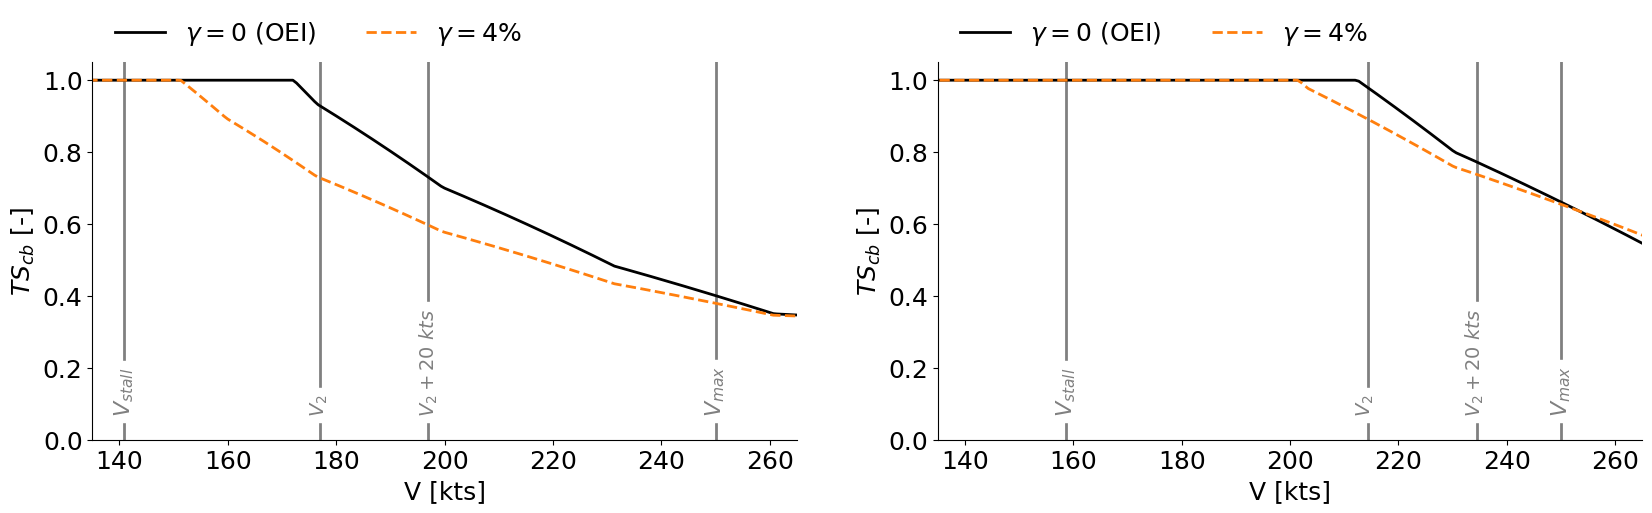

In [64]:
# Figure 
case_lst = ['$\gamma=0$ (OEI)', '$\gamma=4\%$']

fig, ax = plt.subplots(1,2, figsize=(20,5))
plt.style.use('../utils/plot.mplstyle')
for j, ac_name in enumerate(['stca', 'a10']): 

    if ac_name == 'stca':
        ax[j].plot([177, 177], [0., 1.05], 'grey')
        lim1 = ax[j].plot([197, 197], [0., 1.05], 'grey')
        ax[j].annotate(xy=(175, 0.08), s='$V_2$', rotation=90, fontsize=14, backgroundcolor='w', color='grey')
        ax[j].annotate(xy=(195, 0.08), s='$V_2+20\ kts$', rotation=90, fontsize=14, backgroundcolor='w', color='grey')
        ax[j].annotate(xy=(250, 0.08), s='$V_{max}$', rotation=90, fontsize=16, backgroundcolor='w', ha='center', color='grey')

    elif ac_name == 'a10':
        ax[j].plot([214.4, 214.4], [0.,1.05], 'grey')
        lim1 = ax[j].plot([234.4, 234.4], [0.,1.05], 'grey')
        ax[j].annotate(xy=(212., 0.08), s='$V_2$', rotation=90, fontsize=14, backgroundcolor='w', color='grey')
        ax[j].annotate(xy=(232., 0.08), s='$V_2+20\ kts$', rotation=90, fontsize=14, backgroundcolor='w', color='grey')
        ax[j].annotate(xy=(250, 0.08), s='$V_{max}$', rotation=90, fontsize=16, backgroundcolor='w', ha='center', color='grey')

    lim2=ax[j].plot([250, 250], [0., 1.05], 'grey')    
    
    lim3=ax[j].plot(np.array([v_stall[ac_name], v_stall[ac_name]])/0.514444, [0, 1.05], 'grey')
    ax[j].annotate(xy=(v_stall[ac_name]/0.514444, 0.08), s='$V_{stall}$', rotation=90, fontsize=16, backgroundcolor='w', ha='center', color='grey')
    
    color_lst = ['k', 'tab:orange']
    linestyle_lst = ['-', '--']
    for i, case in enumerate(case_lst):
        ax[j].plot(v_lst/0.514444, TS_cutback[ac_name][:,i], linestyle=linestyle_lst[i], label=case, color=color_lst[i])
    
    ax[j].legend(frameon=False, loc='lower left', bbox_to_anchor=(0., 0.98), ncol=2)
    ax[j].set_xlabel('V [kts]')
    ax[j].set_ylabel('$TS_{cb}$ [-]')
    ax[j].set_xlim([135, 265])
    ax[j].set_ylim([0., 1.05])

    ax[j].spines['right'].set_visible(False)
    ax[j].spines['top'].set_visible(False)
    

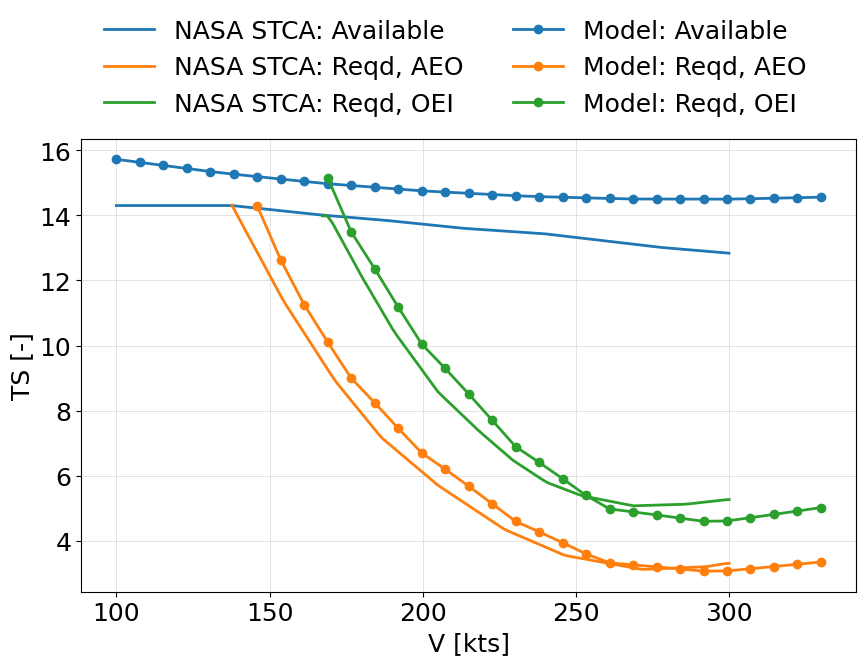

In [24]:
## Verification
if True:
    z_val = 2000.*0.3048
    v_lst_val = np.linspace(100, 330, 31)*0.514444

    # NASA STCA 
    ac_name = 'stca' 
    pyna_settings = pyna.load_settings(case_name=ac_name)
    pyna_settings.ac_name = ac_name
    pyna_settings.engine_file_name = "engine_deck_stca.csv"

    py = pyna(pyna_settings)
    py.ac.load_aerodynamics(settings=py.settings)
    py.engine.load_deck(settings=py.settings)

    # Create engine deck interpolant
    F_n_interp = RegularGridInterpolator((py.engine.deck['z'], py.engine.deck['M_0'], py.engine.deck['TS']), py.engine.deck['F_n'])

    # Compute thrust cut-back level
    F_avail = np.zeros((v_lst_val.size, 2))
    F_req = np.zeros((v_lst_val.size, 2))
    
    for j, v in enumerate(v_lst_val):    
        sol = compute_minimum_TS(ac_name, py.settings, py.ac, py.engine, z_lst=[z_val, z_val], v_lst=[v, v], gamma_lst=[0.0, 0.0])

        F_avail[j,:] = sol['F_avail']
        F_req[j,:] = sol['F_req']

    # STCA data (Berton et al., 2020)
    x1=np.array([137.706612,166.6935938,188.7195653,213.3256804,239.9150885,278.0155327,300.0494528])
    y1=np.array([14.3047876,14.01618056,13.84183866,13.60471812,13.43484652,13.01502654,12.83971283])
    x2=np.array([137.5228273,154.6233646,171.3201978,186.4212453,205.0904386,226.7341667,246.3869082,271.5906836,292.6213643,299.3660994])
    y2=np.array([14.34678879,11.3594587,8.926835194,7.178362751,5.694610124,4.344383572,3.547308706,3.114855262,3.200762867,3.305329138])
    x3=np.array([169.2733324,180.2093836,190.7461847,205.0548058,218.3632771,229.485591,240.4066601,251.9197208,268.7886445,285.8515243,299.5402145])
    y3=np.array([13.98605459,12.10288991,10.41525249,8.568044606,7.37291821,6.469527824,5.794511728,5.381300033,5.07129408,5.1206618,5.264683374])


    plt.figure(figsize=(10,6))
    plt.style.use('../utils/plot.mplstyle')
    x = np.linspace(137.706612, 300.0494528, 100)
#     plt.plot([100, 300], [1,1], label='NASA STCA: Available')
    plt.plot(np.linspace(100, 300, 101), np.interp(np.linspace(100, 300, 101), x1, y1), label='NASA STCA: Available')
    plt.plot(x, np.interp(x, x2, y2), label='NASA STCA: Reqd, AEO')
    plt.plot(x[18:], np.interp(x[18:], x3, y3), label='NASA STCA: Reqd, OEI')

    plt.plot(v_lst_val[:]/0.514444, F_avail[:,1]/1000*0.224809, '-o', color='tab:blue', markersize=6, label='Model: Available')
    plt.plot(v_lst_val[6:]/0.514444, F_req[6:,1]/1000*0.224809, '-o', color='tab:orange', markersize=6, label='Model: Reqd, AEO')
    plt.plot(v_lst_val[9:]/0.514444, F_req[9:,0]/1000*0.224809, '-o', color='tab:green', markersize=6, label='Model: Reqd, OEI')


#     plt.xlim([100, 300])
#     plt.ylim([0,1.1])
    plt.xlabel('V [kts]')
    plt.ylabel('TS [-]')
    plt.legend(frameon=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1.0))